## Trend Calculation [Argentina]


#### Importing the Relevant Libraries

In [31]:
import pandas as pd
import numpy as np
import os
from IPython.display import display
import matplotlib.pyplot as plt
import warnings
import openpyxl
from get_regression_coefs_general import get_regression_coefs # import our function to get GDP trend

#### Cleaning the Data 

In [32]:
# Import the Data from the xlsx file
filename = r"pwt100.xlsx"  

# Load the "Data" sheet and filter for Argentina
df = pd.read_excel(filename, sheet_name="Data", engine="openpyxl")
filtered_df = df[df.iloc[:, 1] == "Argentina"].copy()  # Make an explicit copy

# Index Match the Header
legend_df = pd.read_excel(filename, sheet_name="Legend", engine="openpyxl") # Read the legend sheet
mapping = dict(zip(legend_df.iloc[:, 0].str.strip(), legend_df.iloc[:, 1].str.strip()))  # Clean mapping keys
filtered_df = filtered_df.rename(columns=lambda col: mapping[col] if col in mapping else col)

# Clean to numeric and datetime format
filtered_df.iloc[:, 4:] = filtered_df.iloc[:, 4:].apply(pd.to_numeric, errors='coerce')  # Ensure numeric data
filtered_df['Year'] = pd.to_datetime(filtered_df['Year'], format='%Y', errors='coerce')
filtered_df.reset_index(drop=True)

,3-letter ISO country code,Country name,Currency unit,Year,Expenditure-side real GDP at chained PPPs (in mil. 2017US$),Output-side real GDP at chained PPPs (in mil. 2017US$),Population (in millions),Number of persons engaged (in millions),Average annual hours worked by persons engaged,"Human capital index, based on years of schooling and returns to education; see Human capital in PWT9.",...,Share of merchandise exports at current PPPs,Share of merchandise imports at current PPPs,Share of residual trade and GDP statistical discrepancy at current PPPs,"Price level of household consumption, price level of USA GDPo in 2017=1","Price level of capital formation, price level of USA GDPo in 2017=1","Price level of government consumption, price level of USA GDPo in 2017=1","Price level of exports, price level of USA GDPo in 2017=1","Price level of imports, price level of USA GDPo in 2017=1","Price level of the capital stock, price level of USA in 2017=1","Price level of the capital services, price level of USA=1"
0,ARG,Argentina,Argentine Peso,1950-01-01,50303.9531,50108.7617,17.0918,6.6088,2034.0000,1.8165,...,0.1225,-0.0604,-0.0128,0.1931,0.4227,0.2731,0.1177,0.1078,0.2924,NaN
1,ARG,Argentina,Argentine Peso,1951-01-01,52677.9648,51339.1680,17.4576,6.7133,2037.8668,1.8308,...,0.1005,-0.0748,-0.0165,0.2139,0.3669,0.2779,0.1423,0.1188,0.2648,NaN
2,ARG,Argentina,Argentine Peso,1952-01-01,47677.2070,46855.1016,17.8160,6.8193,2041.7409,1.8451,...,0.0778,-0.0584,-0.0331,0.2296,0.3665,0.2964,0.1263,0.1307,0.2682,NaN
3,ARG,Argentina,Argentine Peso,1953-01-01,49529.6719,49917.1484,18.1686,6.9271,2045.6223,1.8596,...,0.1067,-0.0418,-0.0222,0.2309,0.3702,0.3156,0.1109,0.1024,0.2673,NaN
4,ARG,Argentina,Argentine Peso,1954-01-01,51835.3750,52254.7695,18.5172,7.0365,2049.5112,1.8742,...,0.1086,-0.0515,-0.0292,0.2297,0.3816,0.3278,0.0940,0.0935,0.2737,8.5022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,ARG,Argentina,Argentine Peso,2015-01-01,914850.1875,913103.5000,43.0754,19.8545,1703.4685,2.9753,...,0.0991,-0.1073,-0.0054,0.8146,0.8257,0.4462,0.6339,0.6204,0.5418,1.2154
66,ARG,Argentina,Argentine Peso,2016-01-01,911368.0000,908771.3125,43.5085,19.7232,1646.5125,3.0052,...,0.1022,-0.1009,-0.0139,0.7046,0.7365,0.3780,0.6276,0.6138,0.4678,1.0570
67,ARG,Argentina,Argentine Peso,2017-01-01,1026128.1250,1022513.2500,43.9371,20.0337,1648.8128,3.0354,...,0.0896,-0.1064,0.0112,0.6408,0.7704,0.4984,0.6372,0.6149,0.5125,1.1437
68,ARG,Argentina,Argentine Peso,2018-01-01,1025860.9375,1021129.3125,44.3611,20.1351,1638.4400,3.0660,...,0.0907,-0.1015,0.0365,0.5215,0.6607,0.3768,0.6641,0.6308,0.4129,0.8759


## Trend calculation. Calculate a trend time paths for (the natural logs of) (i) realGDP and (ii) real GDP per capita. 

All at constant 2017 national prices using data over the whole sample. We will provide a simple template Python program that you can use to fit a time trend. Present two panels with the natural logarithm of each variable and the corresponding trend time path.

- As a robustness exercise, use the levels instead of log levels in the trend regression.

### Trend Time Paths

Disclaimer: We fit the trend paths based on a 20 year rolling window. The reason for this is because we believe these time paths are sufficiently long to not capture short term fluctuations but sufficiently short to see long term structural shifts in the economy
 - Additive Linear Model
 - Additive Quadratic Model
 - Exponential Linear Model
 - Exponential Quadratic

##### (i) Real GDP 

##### 1) Additive Linear Model

In [33]:
# Compute separate sample sizes for the subsample used for estimation and the whole sample

years = filtered_df["Year"].dt.year.values # Ensure the years array matches the length of Y
Yhat_add_linear = np.empty(len(years))  # Initialise an empty vector for the estimated GDP trend
ymax = filtered_df["Year"].dt.year.values[-1]  # Maximum year in the data
ymin = filtered_df["Year"].dt.year.values[0]  # Minimum year in the data
Y = filtered_df["Expenditure-side real GDP at chained PPPs (in mil. 2017US$)"].values

# Split years into 10-year periods
for start_year in range(ymin, ymax + 1, 20):
    # Determine the range for this 10-year period
    end_year = min(start_year + 19, ymax)
    period_mask = (years >= start_year) & (years <= end_year)  # Mask for years in the current block
    
    # Extract Y and define regressors for the period (may be less than 10 years for the last block)
    Y_period = Y[period_mask]
    x1 = np.ones(len(Y_period))  # Intercept term
    x2 = np.arange(1, len(Y_period) + 1)  # Time trend term

    # Perform regression only if there are years in the block
    if len(Y_period) > 0:
        a_add_lin, b_add_lin = get_regression_coefs(Y_period, x1, x2)

        # Predict Yhat for this period
        for idx, t in enumerate(np.where(period_mask)[0]):
            Yhat_add_linear[t] = a_add_lin + b_add_lin * (idx + 1)  # Compute predictions


##### 2) Additive Quadratic Model

In [34]:
Yhat_add_quad = np.empty(len(years))  # Initialise an empty vector for the estimated GDP trend
for start_year in range(ymin, ymax + 1, 20):
    # Determine the range for this 10-year period
    end_year = min(start_year + 19, ymax)
    period_mask = (years >= start_year) & (years <= end_year)  # Mask for years in the current block
    
    # Extract Y and define regressors for the period (may be less than 10 years for the last block)
    Y_period = Y[period_mask]
    x1 = np.ones(len(Y_period))  # Intercept term
    x2 = np.arange(1, len(Y_period) + 1)  # Time trend term
    x3 = x2 ** 2  # Quadratic term

    # Perform regression only if there are years in the block
    if len(Y_period) > 0:
        a_add_quad, b_add_quad, c_add_quad = get_regression_coefs(Y_period, x1, x2,x3)

        # Predict Yhat for this period
        for idx, t in enumerate(np.where(period_mask)[0]):
            Yhat_add_quad[t] = a_add_quad + b_add_quad * (idx + 1) + c_add_quad * (idx + 1)**2  # Compute predictions


##### Plotting Additive Models

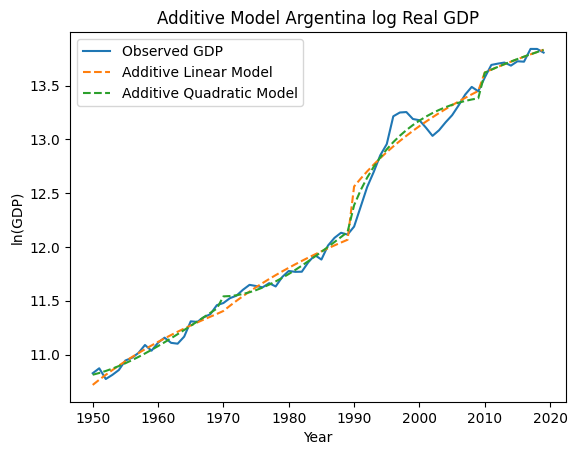

In [35]:
# Plot the results
plt.figure()
plt.plot(filtered_df["Year"], np.log(filtered_df["Expenditure-side real GDP at chained PPPs (in mil. 2017US$)"]), label="Observed GDP")
plt.plot(filtered_df["Year"], np.log(Yhat_add_linear), label="Additive Linear Model", linestyle="--")
plt.plot(filtered_df["Year"], np.log(Yhat_add_quad), label="Additive Quadratic Model", linestyle="--")

# Add labels and title
plt.xlabel("Year")
plt.ylabel("ln(GDP)")
plt.title("Additive Model Argentina log Real GDP")
plt.legend()
plt.show()

##### 3) Exponential Linear Model

In [36]:
Yhat_exp_linear = np.empty(len(years))  # Initialise an empty vector for the estimated GDP trend
for start_year in range(ymin, ymax + 1, 20):
    # Determine the range for this 20-year period
    end_year = min(start_year + 19, ymax)
    period_mask = (years >= start_year) & (years <= end_year)  # Mask for years in the current block
    
    # Extract Y and define regressors for the period
    Y_period = Y[period_mask]
    x1 = np.ones(len(Y_period))  # Intercept term
    x2 = np.exp(np.arange(1, len(Y_period) + 1))  

    # Perform regression only if there are years in the block
    if len(Y_period) > 0:
        # Transform Y for exponential growth
        log_Y_period = np.log(Y_period)  # Take logarithm to linearize exponential trend -- Key difference!!
        a_exp_lin, b_exp_lin = get_regression_coefs(log_Y_period, x1, x2)

        # Predict Yhat for this period
        for idx, t in enumerate(np.where(period_mask)[0]):
            Yhat_exp_linear[t] = a_exp_lin + b_exp_lin * np.exp(idx + 1)  # Exponentiate to get back to original scale

##### 4) Exponential Quadratic Model

In [37]:
Yhat_exp_quad = np.empty(len(years))  # Initialise an empty vector for the estimated GDP trend
for start_year in range(ymin, ymax + 1, 20):
    # Determine the range for this 20-year period
    end_year = min(start_year + 19, ymax)
    period_mask = (years >= start_year) & (years <= end_year)  # Mask for years in the current block
    
    # Extract Y and define regressors for the period
    Y_period = Y[period_mask]
    x1 = np.ones(len(Y_period))  # Intercept term
    t = np.arange(1, len(Y_period) + 1)  # Time indices for the block
    x2 = t  # Linear time trend
    x3 = t ** 2  # Quadratic time trend
    # Perform regression only if there are years in the block
    
    if len(Y_period) > 0:
        # Fit the regression model
        a_exp_quad, b_exp_quad, c_exp_quad = get_regression_coefs(Y_period, x1, x2, x3)

        # Predict Yhat for this period using exponential transformations during prediction
        for idx, t in enumerate(np.where(period_mask)[0]):
            Yhat_exp_quad[t] = (
                a_exp_quad
                + b_exp_quad * np.exp(idx + 1)  # Exponential of linear trend
                + c_exp_quad * np.exp((idx + 1) ** 2)  # Exponential of quadratic trend
            )

##### Plotting Exponential Models

- Note that there is a very large outlier in the exponential quadratic model! Hence it is currently excluded. Up for discussion what to do

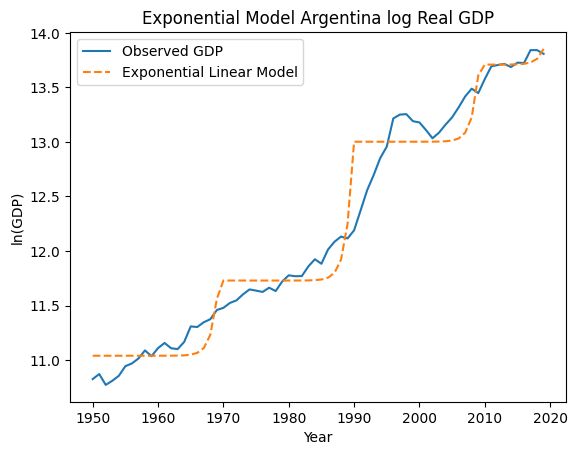

In [38]:
# Plot the results
plt.figure()
plt.plot(filtered_df["Year"], np.log(filtered_df["Expenditure-side real GDP at chained PPPs (in mil. 2017US$)"]), label="Observed GDP")
plt.plot(filtered_df["Year"], Yhat_exp_linear, label="Exponential Linear Model", linestyle="--")
 # plt.plot(filtered_df["Year"], Yhat_exp_quad, label="Exponential Quadratic Model", linestyle="--")
# Add labels and title
plt.xlabel("Year")
plt.ylabel("ln(GDP)")
plt.title("Exponential Model Argentina log Real GDP")
plt.legend()
plt.show()

### BELOW IS A DIFFERENT WAY OF TACKLING PART A

In [39]:
# Initialise predicted values yhat
T_all = data["year"].max() - (ymin - 1) # number of all years in the data after ymin
Yhat_add_quad = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_add_quad[t] = a_add_quad + b_add_quad * (t + 1) + c_add_quad * (t+1) ** 2 # recall that Python indexing starts at 0

# Let us convert into log-units
yhat_add_quad= np.log(Yhat_add_quad)

plt.figure()
#one could add options such as a particular size and use instead
#plt.figure(figsize=(7, 5))
plt.plot(filtered_df['Year'],np.log(filtered_df['Expenditure-side real GDP at chained PPPs (in mil. 2017US$)']))
plt.plot(filtered_df['Year'],yhat_add_quad) # Value already logged

#labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")

#title
plt.title("Additive Quadratic: GDP & trend")




NameError: name 'data' is not defined

##### (i) Real GDP - 3) Exponential Linear Model

In [ ]:
# 3.3) Exponential Linear Model

x1 = np.empty(T) # initialise an empty vector for the first regressor
x2 = np.empty(T) # initialise an empty vector for the second regressor

for t in range(T):
    x1[t] = 1.
    x2[t] = np.exp(t + 1) # recall that Python starts indexing at 0

a_exp_linear, b_exp_linear = get_regression_coefs(Y, x1, x2)

NameError: name 'T' is not defined

In [ ]:
# Initialise predicted values yhat
Yhat_exp_linear = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_exp_linear[t] = a_exp_linear + b_exp_linear * np.exp(t+1)  # recall that Python indexing starts at 0

# Let us convert into log-units
Yhat_exp_linear= np.log(Yhat_exp_linear)

plt.figure()
#one could add options such as a particular size and use instead
#plt.figure(figsize=(7, 5))
plt.plot(filtered_df['Year'],np.log(filtered_df['Expenditure-side real GDP at chained PPPs (in mil. 2017US$)']))
plt.plot(filtered_df['Year'],Yhat_exp_linear) # Value already logged

#labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")

#title
plt.title("Exponential Linear: GDP & trend")

NameError: name 'T_all' is not defined

##### (i) Real GDP - 4) Exponential Quadratic Model

In [ ]:
# 3.3) Exponential Quadratic Model

x1 = np.empty(T) # initialise an empty vector for the first regressor
x2 = np.empty(T) # initialise an empty vector for the second regressor
scaling_factor = 1000
for t in range(T):
    x1[t] = 1.
    x2[t] = np.exp(t + 1) # recall that Python starts indexing at 0
    x3[t] = np.exp((t + 1) ** 2 / scaling_factor)

a_exp_quad, b_exp_quad, c_exp_quad = get_regression_coefs(Y, x1, x2,x3)

NameError: name 'T' is not defined

Text(0.5, 1.0, 'Exponential Linear: GDP & trend')

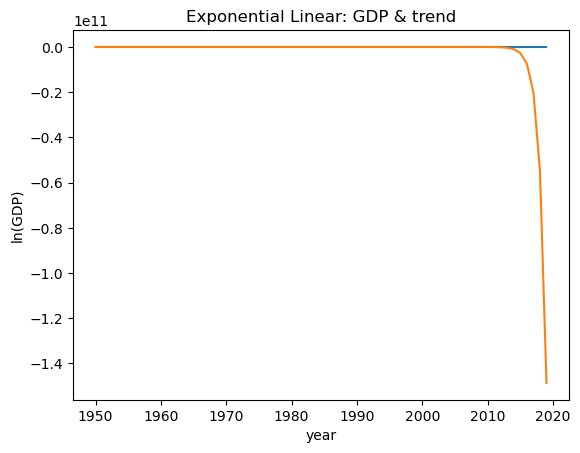

In [ ]:
# Initialise predicted values yhat
Yhat_exp_quad = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_exp_quad[t] = a_exp_quad + b_exp_quad * np.exp(t+1) + c_exp_quad * np.exp((t+1)**2/scaling_factor)  # recall that Python indexing starts at 0

# Let us convert into log-units
Yhat_exp_linear= np.log(Yhat_exp_linear)

plt.figure()
#one could add options such as a particular size and use instead
#plt.figure(figsize=(7, 5))
plt.plot(filtered_df['Year'],np.log(filtered_df['Expenditure-side real GDP at chained PPPs (in mil. 2017US$)']))
plt.plot(filtered_df['Year'],Yhat_exp_quad) # Value already logged

#labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")

#title
plt.title("Exponential Linear: GDP & trend")

##### (ii) Real GDP per Capita

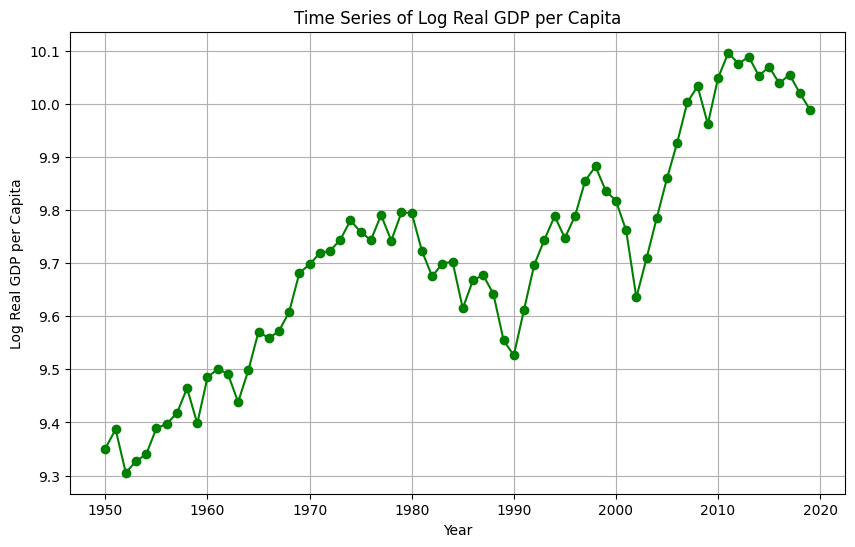

In [ ]:
# Columns for Real GDP and Population
gdp_column = "Real GDP at constant 2017 national prices (in mil. 2017US$)"
population_column = "Population (in millions)"
gdp_per_capita_column = "Log Real GDP per capita"

# Calculate Real GDP per capita and take the bnatural log
if all(col in filtered_df.columns for col in [gdp_column, population_column]):
    filtered_df[gdp_per_capita_column] = [
        np.log(gdp / pop) if pd.notnull(gdp) and pd.notnull(pop) and pop > 0 else np.nan
        for gdp, pop in zip(filtered_df[gdp_column], filtered_df[population_column])
    ]
else:
    raise KeyError(f"Columns '{gdp_column}' or '{population_column}' not found in DataFrame.")

# Plot the time series graph
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Year'], filtered_df[gdp_per_capita_column], color='green', linestyle='-', marker='o')
plt.xlabel('Year')
plt.ylabel('Log Real GDP per Capita')
plt.title('Time Series of Log Real GDP per Capita')
plt.grid(True)
plt.show()


### Part B : Extracting TFP Measure

$$
Y = A K^\alpha (L)^{1-\alpha}, \quad 0 < \alpha < 1
$$

We will be using a Neutral Cobb-Douglas Production Function as expressed above. 

$$
A = \frac{Y}{K^\alpha L^{1-\alpha}}, \quad 0 < \alpha < 1
$$


In [40]:
# Assume alpha = 0.3
alpha = 0.3

filtered_df.reset_index(drop=True).columns

# h = "Human capital index, based on years of schooling and returns to education; see Human capital in PWT9."
Y = "Real GDP at constant 2017 national prices (in mil. 2017US$)"
K = "Capital stock at constant 2017 national prices (in mil. 2017US$)"
l = "Number of persons engaged (in millions)"
avh = "Average annual hours worked by persons engaged"

# Use apply function to calculate TFP for each row based on the values in the columns. We define labour as the product of the number of persons engaged and average annual hours worked.
filtered_df['log A (Total Factor Productivity)'] = filtered_df.apply(
    lambda row: row[Y] / (row[K] ** alpha * (row[l] * row[avh]) ** (1 - alpha)),
    axis=1
).apply(np.log)  # Take the natural logarithm of the TFP values

filtered_df


,3-letter ISO country code,Country name,Currency unit,Year,Expenditure-side real GDP at chained PPPs (in mil. 2017US$),Output-side real GDP at chained PPPs (in mil. 2017US$),Population (in millions),Number of persons engaged (in millions),Average annual hours worked by persons engaged,"Human capital index, based on years of schooling and returns to education; see Human capital in PWT9.",...,Share of merchandise imports at current PPPs,Share of residual trade and GDP statistical discrepancy at current PPPs,"Price level of household consumption, price level of USA GDPo in 2017=1","Price level of capital formation, price level of USA GDPo in 2017=1","Price level of government consumption, price level of USA GDPo in 2017=1","Price level of exports, price level of USA GDPo in 2017=1","Price level of imports, price level of USA GDPo in 2017=1","Price level of the capital stock, price level of USA in 2017=1","Price level of the capital services, price level of USA=1",log A (Total Factor Productivity)
350,ARG,Argentina,Argentine Peso,1950-01-01,50303.9531,50108.7617,17.0918,6.6088,2034.0000,1.8165,...,-0.0604,-0.0128,0.1931,0.4227,0.2731,0.1177,0.1078,0.2924,NaN,1.6964
351,ARG,Argentina,Argentine Peso,1951-01-01,52677.9648,51339.1680,17.4576,6.7133,2037.8668,1.8308,...,-0.0748,-0.0165,0.2139,0.3669,0.2779,0.1423,0.1188,0.2648,NaN,1.7134
352,ARG,Argentina,Argentine Peso,1952-01-01,47677.2070,46855.1016,17.8160,6.8193,2041.7409,1.8451,...,-0.0584,-0.0331,0.2296,0.3665,0.2964,0.1263,0.1307,0.2682,NaN,1.6205
353,ARG,Argentina,Argentine Peso,1953-01-01,49529.6719,49917.1484,18.1686,6.9271,2045.6223,1.8596,...,-0.0418,-0.0222,0.2309,0.3702,0.3156,0.1109,0.1024,0.2673,NaN,1.6302
354,ARG,Argentina,Argentine Peso,1954-01-01,51835.3750,52254.7695,18.5172,7.0365,2049.5112,1.8742,...,-0.0515,-0.0292,0.2297,0.3816,0.3278,0.0940,0.0935,0.2737,8.5022,1.6335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,ARG,Argentina,Argentine Peso,2015-01-01,914850.1875,913103.5000,43.0754,19.8545,1703.4685,2.9753,...,-0.1073,-0.0054,0.8146,0.8257,0.4462,0.6339,0.6204,0.5418,1.2154,2.0393
416,ARG,Argentina,Argentine Peso,2016-01-01,911368.0000,908771.3125,43.5085,19.7232,1646.5125,3.0052,...,-0.1009,-0.0139,0.7046,0.7365,0.3780,0.6276,0.6138,0.4678,1.0570,2.0418
417,ARG,Argentina,Argentine Peso,2017-01-01,1026128.1250,1022513.2500,43.9371,20.0337,1648.8128,3.0354,...,-0.1064,0.0112,0.6408,0.7704,0.4984,0.6372,0.6149,0.5125,1.1437,2.0498
418,ARG,Argentina,Argentine Peso,2018-01-01,1025860.9375,1021129.3125,44.3611,20.1351,1638.4400,3.0660,...,-0.1015,0.0365,0.5215,0.6607,0.3768,0.6641,0.6308,0.4129,0.8759,2.0205


#### Plotting a time-series for TFP

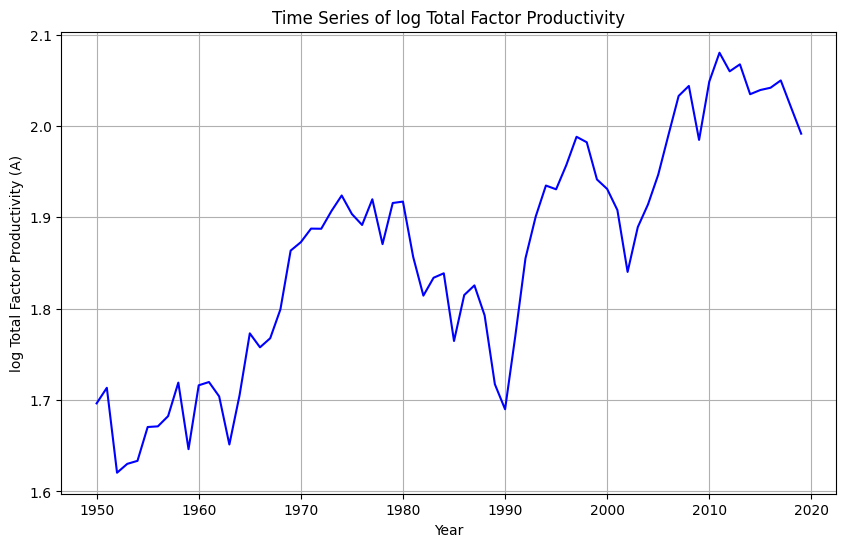

In [41]:
# Express the TFP as a value relative to the first year where 1950 is 100
# filtered_df['A (TFP) Relative'] = 100 * filtered_df['A (TFP)'] / filtered_df.loc[filtered_df['Year'].dt.year == 1960, 'A (TFP)'].values[0]


# Create a time-series graph plotting the TFP over time
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Year'], filtered_df['log A (Total Factor Productivity)'], color='blue', linestyle='-')
plt.xlabel('Year')
plt.ylabel('log Total Factor Productivity (A)')
plt.title('Time Series of log Total Factor Productivity')
plt.grid(True)

### Part C : Growth Accounting

In [42]:
def compute_growth_rate(X):
    #np.log is the natural logarithm by default in numpy
    #use of index slicing, e.g. X[1:] are all values starting from the second element, X[:-1] all elements up until (but not including) the last element
    return np.log(X[1:] / X[:-1])

dY = compute_growth_rate(filtered_df[Y].values)
dA = filtered_df['log A (Total Factor Productivity)'].values[1:] - filtered_df['log A (Total Factor Productivity)'].values[:-1]
dK = compute_growth_rate(filtered_df[K].values)
dL = compute_growth_rate((filtered_df[l] * filtered_df[avh]).values)


$$
\begin{aligned}
\text{contr\_K} &= \alpha \cdot \frac{g_K}{g_Y} \\
\text{contr\_L} &= (1 - \alpha) \cdot \frac{g_L}{g_Y} \\
\text{contr\_A} &= \frac{g_A}{g_Y}
\end{aligned}
$$

In [43]:
# calculate contributions
contrib_dK = alpha * dK / dY
contrib_dL = (1 - alpha) * dL / dY
contrib_dA = dA / dY
year = filtered_df['Year'].dt.year.values

# Display growth rates
print("\t == year by year growth rate ==\n")
print("\t year \t \t ln(Y_t/Y_{t-1}) ")
print("\t ------- \t ------ ")
for y1, y2, growth in zip(year[:-1], year[1:], dY):
    print(f"\t {y1:.0f}-{y2:.0f} \t {growth:.4f}")

	 == year by year growth rate ==

	 year 	 	 ln(Y_t/Y_{t-1}) 
	 ------- 	 ------ 
	 1950-1951 	 0.0574
	 1951-1952 	 -0.0614
	 1952-1953 	 0.0413
	 1953-1954 	 0.0320
	 1954-1955 	 0.0675
	 1955-1956 	 0.0260
	 1956-1957 	 0.0377
	 1957-1958 	 0.0640
	 1958-1959 	 -0.0496
	 1959-1960 	 0.1031
	 1960-1961 	 0.0320
	 1961-1962 	 0.0064
	 1962-1963 	 -0.0374
	 1963-1964 	 0.0748
	 1964-1965 	 0.0880
	 1965-1966 	 0.0024
	 1966-1967 	 0.0275
	 1967-1968 	 0.0504
	 1968-1969 	 0.0877
	 1969-1970 	 0.0315
	 1970-1971 	 0.0369
	 1971-1972 	 0.0206
	 1972-1973 	 0.0368
	 1973-1974 	 0.0526
	 1974-1975 	 -0.0059
	 1975-1976 	 -0.0001
	 1976-1977 	 0.0619
	 1977-1978 	 -0.0327
	 1978-1979 	 0.0678
	 1979-1980 	 0.0144
	 1980-1981 	 -0.0557
	 1981-1982 	 -0.0321
	 1982-1983 	 0.0403
	 1983-1984 	 0.0199
	 1984-1985 	 -0.0721
	 1985-1986 	 0.0690
	 1986-1987 	 0.0250
	 1987-1988 	 -0.0197
	 1988-1989 	 -0.0727
	 1989-1990 	 -0.0135
	 1990-1991 	 0.0998
	 1991-1992 	 0.0981
	 1992-1993 	 0.0606
	 1

In [44]:
# Compute yearly intervals of the form "2000-2001"
intvls = np.array([f"{y1}-{y2}" for y1, y2 in zip(year[:-1], year[1:])])

# Fill in the dataframe
df_contribs = pd.DataFrame(
    data = np.hstack((intvls[:, None], contrib_dK[:, None], contrib_dL[:, None], contrib_dA[:, None])),
    columns = ['year', 'K contribution', 'L contribution', 'A contribution']
)

# Specify the data types for specific columns (it would be more efficient to define datatypes already before creating dataframe)
df_contribs = df_contribs.astype({
    'year': 'object',
    'K contribution': 'float64',
    'L contribution': 'float64',
    'A contribution': 'float64',
})

# Set index
df_contribs = df_contribs.set_index('year')

# Set display options
pd.set_option('display.float_format', '{:.4f}'.format)

# Dispaly contribution table
print(df_contribs)

           K contribution  L contribution  A contribution
year                                                     
1950-1951          0.4887          0.2144          0.2969
1951-1952         -0.3130         -0.2003          1.5134
1952-1953          0.4675          0.2977          0.2348
1953-1954          0.5134          0.3840          0.1027
1954-1955          0.2694          0.1822          0.5484
...                   ...             ...             ...
2014-2015          0.2353          0.5944          0.1703
2015-2016         -0.2351          1.3532         -0.1181
2016-2017          0.2434          0.4523          0.3044
2017-2018         -0.2005          0.0351          1.1653
2018-2019         -0.1067         -0.2188          1.3255

[69 rows x 3 columns]


In [45]:
## Create a DataFrame to store average growth rates
avg_growth_rates = pd.DataFrame(
    data=np.full((4, 4), np.nan),  # 4 intervals, 4 growth metrics
    columns=['Y growth', 'K growth', 'L growth', 'A growth']
)
avg_growth_rates['year'] = ["1950-1976", "1977-1990", "1991-2001", "2002-2017"]
avg_growth_rates = avg_growth_rates.set_index('year')

# Define column names for growth rate calculations
cols = [Y, K, l, avh, 'log A (Total Factor Productivity)']

# Fill with average growth rates for the defined intervals
avg_growth_rates.loc['1950-1976'] = np.log(
    filtered_df.loc[filtered_df['Year'].dt.year == 1976, [Y, K]].iloc[0].values /
    filtered_df.loc[filtered_df['Year'].dt.year == 1950, [Y, K]].iloc[0].values
).tolist() + [
    np.log(
        (filtered_df.loc[filtered_df['Year'].dt.year == 1976, l].iloc[0] *
         filtered_df.loc[filtered_df['Year'].dt.year == 1976, avh].iloc[0]) /
        (filtered_df.loc[filtered_df['Year'].dt.year == 1950, l].iloc[0] *
         filtered_df.loc[filtered_df['Year'].dt.year == 1950, avh].iloc[0])
    ),
    filtered_df.loc[filtered_df['Year'].dt.year == 1976, 'log A (Total Factor Productivity)'].iloc[0] -
    filtered_df.loc[filtered_df['Year'].dt.year == 1950, 'log A (Total Factor Productivity)'].iloc[0]
]

avg_growth_rates.loc['1977-1990'] = np.log(
    filtered_df.loc[filtered_df['Year'].dt.year == 1990, [Y, K]].iloc[0].values /
    filtered_df.loc[filtered_df['Year'].dt.year == 1977, [Y, K]].iloc[0].values
).tolist() + [
    np.log(
        (filtered_df.loc[filtered_df['Year'].dt.year == 1990, l].iloc[0] *
         filtered_df.loc[filtered_df['Year'].dt.year == 1990, avh].iloc[0]) /
        (filtered_df.loc[filtered_df['Year'].dt.year == 1977, l].iloc[0] *
         filtered_df.loc[filtered_df['Year'].dt.year == 1977, avh].iloc[0])
    ),
    filtered_df.loc[filtered_df['Year'].dt.year == 1990, 'log A (Total Factor Productivity)'].iloc[0] -
    filtered_df.loc[filtered_df['Year'].dt.year == 1977, 'log A (Total Factor Productivity)'].iloc[0]
]

avg_growth_rates.loc['1991-2001'] = np.log(
    filtered_df.loc[filtered_df['Year'].dt.year == 2001, [Y, K]].iloc[0].values /
    filtered_df.loc[filtered_df['Year'].dt.year == 1991, [Y, K]].iloc[0].values
).tolist() + [
    np.log(
        (filtered_df.loc[filtered_df['Year'].dt.year == 2001, l].iloc[0] *
         filtered_df.loc[filtered_df['Year'].dt.year == 2001, avh].iloc[0]) /
        (filtered_df.loc[filtered_df['Year'].dt.year == 1991, l].iloc[0] *
         filtered_df.loc[filtered_df['Year'].dt.year == 1991, avh].iloc[0])
    ),
    filtered_df.loc[filtered_df['Year'].dt.year == 2001, 'log A (Total Factor Productivity)'].iloc[0] -
    filtered_df.loc[filtered_df['Year'].dt.year == 1991, 'log A (Total Factor Productivity)'].iloc[0]
]

avg_growth_rates.loc['2002-2017'] = np.log(
    filtered_df.loc[filtered_df['Year'].dt.year == 2017, [Y, K]].iloc[0].values /
    filtered_df.loc[filtered_df['Year'].dt.year == 2002, [Y, K]].iloc[0].values
).tolist() + [
    np.log(
        (filtered_df.loc[filtered_df['Year'].dt.year == 2017, l].iloc[0] *
         filtered_df.loc[filtered_df['Year'].dt.year == 2017, avh].iloc[0]) /
        (filtered_df.loc[filtered_df['Year'].dt.year == 2002, l].iloc[0] *
         filtered_df.loc[filtered_df['Year'].dt.year == 2002, avh].iloc[0])
    ),
    filtered_df.loc[filtered_df['Year'].dt.year == 2017, 'log A (Total Factor Productivity)'].iloc[0] -
    filtered_df.loc[filtered_df['Year'].dt.year == 2002, 'log A (Total Factor Productivity)'].iloc[0]
]

# Compute contribution rates
df_contribs_long = avg_growth_rates.copy()
df_contribs_long['K contribution'] = alpha * (df_contribs_long['K growth'] / df_contribs_long['Y growth'])
df_contribs_long['L contribution'] = (1 - alpha) * (df_contribs_long['L growth'] / df_contribs_long['Y growth'])
df_contribs_long['A contribution'] = df_contribs_long['A growth'] / df_contribs_long['Y growth']

# Only keep selected columns
df_contribs_long = df_contribs_long[['Y growth', 'K contribution', 'L contribution', 'A contribution']]

# Display the results
pd.set_option('display.float_format', '{:.4f}'.format)
print(df_contribs_long)


           Y growth  K contribution  L contribution  A contribution
year                                                               
1950-1976    0.8221          0.4924          0.2701          0.2375
1977-1990   -0.0621         -1.0820         -1.6167          3.6986
1991-2001    0.2687          0.2572          0.2286          0.5142
2002-2017    0.5734          0.1892          0.4453          0.3655


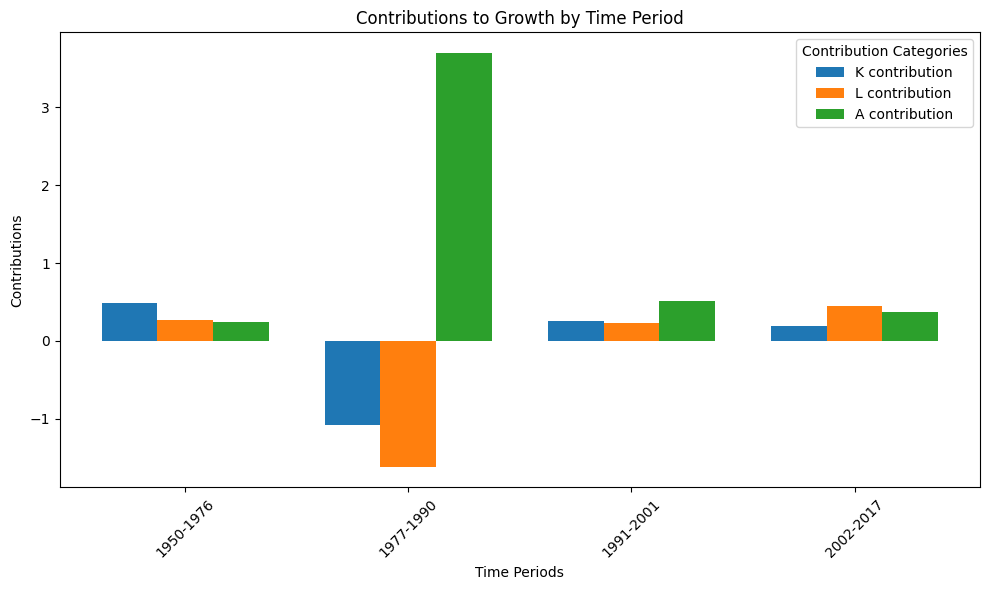

In [46]:
# Reset the index for plotting
df_contribs_long_plot = df_contribs_long.reset_index()
df_contribs_long_plot.rename(columns={'index': 'year'}, inplace=True)

# Extract data for plotting
time_periods = df_contribs_long_plot['year']
categories = ['K contribution', 'L contribution', 'A contribution']
values = df_contribs_long_plot[categories].values

# Create a bar plot
x = range(len(time_periods))  # Position of groups
width = 0.25  # Width of each bar
offsets = [-width, 0, width]  # Offsets for grouped bars

plt.figure(figsize=(10, 6))

# Plot each contribution category
for i, category in enumerate(categories):
    plt.bar(
        [pos + offsets[i] for pos in x],  # Adjust positions for grouping
        values[:, i],  # Contribution values for the category
        width,
        label=category
    )

# Formatting the plot
plt.xlabel('Time Periods')
plt.ylabel('Contributions')
plt.title('Contributions to Growth by Time Period')
plt.xticks(x, time_periods, rotation=45)
plt.legend(title='Contribution Categories')
plt.tight_layout()

# Show the plot
plt.show()

In [47]:
# Decomposing the contribution of A as a product of A* and Ht where Ht is the human capital index



### Part D : Extracting Labour Productivity

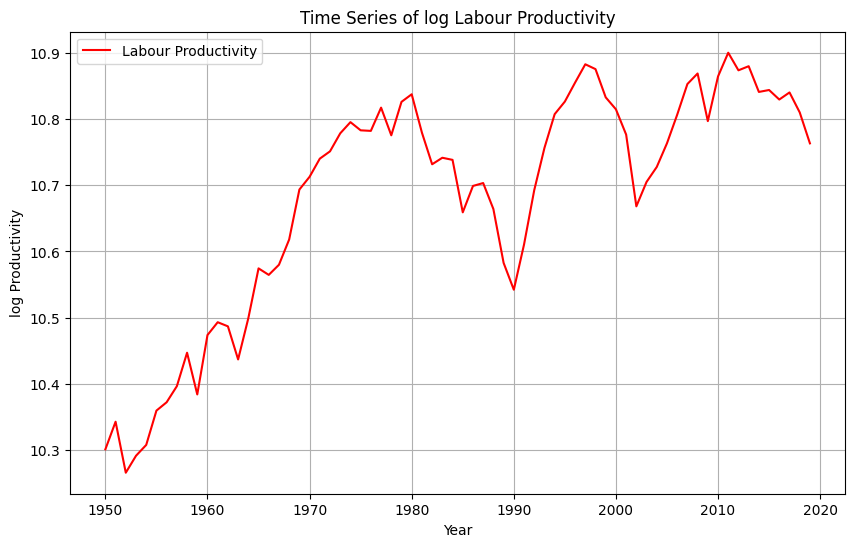

In [48]:
filtered_df['Labour Productivity'] = np.log(filtered_df['Real GDP at constant 2017 national prices (in mil. 2017US$)'] / (filtered_df['Number of persons engaged (in millions)']))

# Plot a time series graph of labour productivity and total factor productivity, normalise y-values using log
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Year'], filtered_df['Labour Productivity'], color='red', linestyle='-', label='Labour Productivity')
#plt.plot(filtered_df['Year'], filtered_df['A (TFP) Relative'], color='blue', linestyle='-', label='Total Factor Productivity')
plt.xlabel('Year')
plt.ylabel('log Productivity')
plt.title('Time Series of log Labour Productivity')
plt.legend()
plt.grid(True)
plt.show()

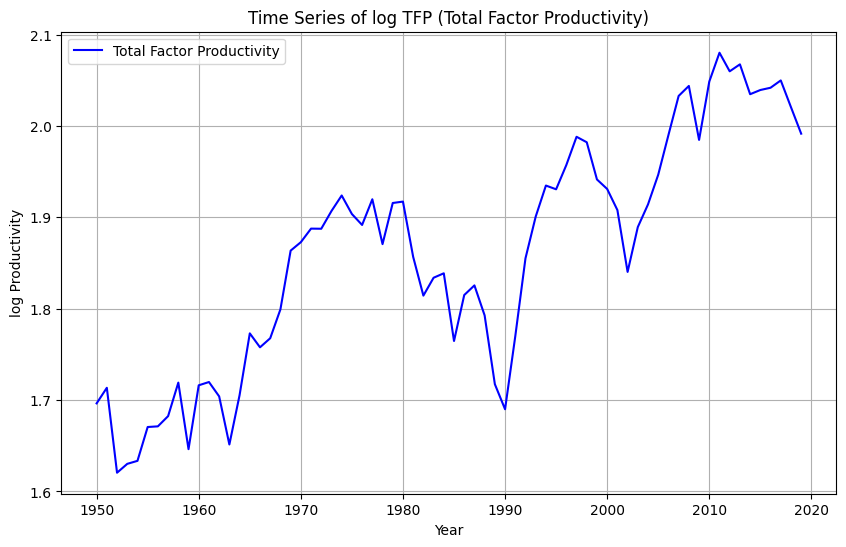

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Year'], filtered_df['log A (Total Factor Productivity)'], color='blue', linestyle='-', label='Total Factor Productivity')
plt.xlabel('Year')
plt.ylabel('log Productivity')
plt.title('Time Series of log TFP (Total Factor Productivity)')
plt.legend()
plt.grid(True)
plt.show()

## Description Part of the Project

### 2. Solow Model - Is the Solow model capable of explaining part of the growth developments in your allocated country?

### 4. Romer model - Is the Romer model useful to explain part of the growth patterns in your country? This does not have to be the Romer model with constant parameters. Also, it is perfectly fine to be critical of the Romer model if your country does not provide support.